<h2>Лабораторна робота №7       ФБ-33 Лозенко Павло   </h2>

<h4>Сценарії обробки багатоспектральних супутникових зображень<h4>

Мета роботи: ознайомитися з основними принципами обробки даних
дистанційного зондування Землі (ДЗЗ) та можливостями мови Python для
обробки геопросторової інформації, а саме, багатоспектральних
супутникових зображень засобами бібліотеки абстракції супутникової
інформації (GDAL).
Основні поняття: дані ДЗЗ (remote sensing data), супутникові зображення
(satellite imagery), обробка зображень (image processing).

Постановка задачі

Лабораторна робота має дві частини. У першій (простішій) частині (пп. 1–
2) необхідно працювати з даними Sentinel-2, які необхідно завантажити за
допомогою Copernicus Scihub за ідентифікаторами (список ідентифікаторів
дивись нижче) або скористатися архівом, що надається викладачем. У
другій (складнішій) частині (п. 4) потрібно також самостійно завантажити
дані Landsat з порталу USGS. Для цього підійдуть будь які 2 сусідніх знімки
Ladsat-8 з відсотком хмарності до 30%, (рекомендовані ідентифікатори
наведено внизу у п. 3).

In [8]:
import os
import traceback
import logging
import subprocess
from pathlib import Path
from typing import List
import geopandas as gpd
import glob
from glob import glob
from osgeo import gdal, osr
import rasterio
from rasterio.plot import show
import pyproj
import numpy as np
from sentinelhub.aws.request import download_safe_format
import matplotlib.pyplot as plt
import sklearn.metrics
import shapely.wkt
import sklearn.metrics
from tqdm import tqdm


print("done")

done


# Sentinel-2

<h3>Завдання 1</h3>

За допомогою бібліотеки sentinelhub написати скрипт для
завантаження супутникових знімків Sentinel-2, які покривають Київ<br>
<p>
(ROI — POLYGON((29.073321247506765 49.845775018245774,<br>
31.986007792928522 49.845775018245774,<br>
31.986007792928522 51.278667808079206,<br>
29.073321247506765 51.278667808079206,<br>
29.073321247506765 49.845775018245774)))<br>
</p>
Список ідентифікаторів Sentinel-2:<br>
<i>– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206<br>
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206</i>

<h3>Code</h3>

In [9]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def download_data_sentinel_2(product_ids: List[str], directory: str) -> None:
    """
    Завантажує дані з Sentinel-2 з використанням sentinelhub.aws.request.download_safe_format.

    Args:
        product_ids (List[str]): Список ідентифікаторів продуктів Sentinel-2 для завантаження.
        directory (str): Шлях до директорії, куди будуть завантажені дані.

    Returns:
        None
    """
    if not isinstance(product_ids, list):
        raise TypeError("product_ids повинен бути списком рядків")
    if not isinstance(directory, str):
        raise TypeError("directory повинен бути рядком")

    for product_id in product_ids:
        logger.info(f"Завантажуємо {product_id}...")
        try:
            download_safe_format(
                product_id=product_id,
                folder=directory,
                entire_product=True,
                redownload=False
            )
        except Exception as e:
            logger.error(f"Помилка під час завантаження {product_id}: {e}")
            traceback.print_exc()

In [ ]:
config = SHConfig()
config.sh_client_id = '6667b912-39a0-42fd-8a00-a37206a9cfd2'
config.sh_client_secret = 'NQ1xKu2WmSoss7606VqaJl8DlT883pEY'

try:

    result = subprocess.run(cmd, shell=True, check=True, capture_output=True, text=True)
    

    print(result.stdout)
    print("Setup!")
    

    if result.stderr:
        print(result.stderr)
        
except subprocess.CalledProcessError as e:

    print(f"Помилка під час виконання команди: {e}")
    print(e.stdout)
    print(e.stderr)


Setup!


<h3>Product ID set and call function for download data</h3>

In [ ]:
product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
]
directory = "./method_FIRST"
download_data_sentinel_2(product_ids, directory)

<h3>Creating .SHP .QPJ .PRJ files from polygon Kyiv</h3>

In [ ]:
def POLYGON_convert(directory):
    fieldCoordinatesAsTextInWKTInEPSG4326 = "POLYGON((29.073321247506765 49.845775018245774, " \
        "31.986007792928522 49.845775018245774, " \
        "31.986007792928522 51.278667808079206, " \
        "29.073321247506765 51.278667808079206, " \
        "29.073321247506765 49.845775018245774))"

    f = Path.cwd().joinpath(directory)
    if not f.is_dir():
        f.mkdir()

    f_shp = f.joinpath("Kyiv_regions.shp")
    gpd.GeoDataFrame(geometry=[shapely.wkt.loads(fieldCoordinatesAsTextInWKTInEPSG4326)]).to_file(str(f_shp))
    print("Було створено .SHP файл...")

    # Створення файлу .qpj
    f_qpj = f.joinpath("Kyiv_regions.qpj")
    with open(f_qpj, 'w') as qpj_file:
        qpj_file.write('GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",'
                    'ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0],'
                    'UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')
    print("Було створено .QPJ файл...")

    # Створення файлу .prj
    f_prj = f.joinpath("Kyiv_regions.prj")
    crs = pyproj.CRS.from_epsg(4326)
    with open(f_prj, 'w') as prj_file:
        prj_file.write(crs.to_wkt())
    print("Було створено .PRJ файл...")

directory = "method_FIRST"
POLYGON_convert(directory)

Було створено .SHP файл...
Було створено .QPJ файл...
Було створено .PRJ файл...


Sentinel-2 satellite data downloaded

Конкатенація каналів видимого, ближнього та середнього
інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в
єдиний GEOTIFF файл.

In [8]:
def concatenation(directory, concatenated_directory):
    result_dir_concatenation = os.path.join(concatenated_directory, "concatenated")
    if not os.path.exists(result_dir_concatenation):
        os.makedirs(result_dir_concatenation)

    resolutions = [10, 20, 60]
    for resolution in resolutions:
        print(f"Preparing image data for resolution: {resolution}")
        img_path = os.path.join(directory, f"R{resolution}m")

        # Find band paths
        band_2_path = glob(os.path.join(img_path, f"*B02_{resolution}m.jp2"))[0]
        band_3_path = glob(os.path.join(img_path, f"*B03_{resolution}m.jp2"))[0]
        band_4_path = glob(os.path.join(img_path, f"*B04_{resolution}m.jp2"))[0]
        band_8_path = glob(os.path.join(img_path, f"*_*_B*8*_{resolution}m.jp2"))[0]
        bands_path = [band_2_path, band_3_path, band_4_path, band_8_path]

        # Merge bands
        gm = "gdal_merge.py"
        output = os.path.join(result_dir_concatenation, f"output_R{resolution}m.tif")
        merge_command = [gm, "-separate", "-o", output] + bands_path
        subprocess.run(merge_command)
    

<h3>Call method of concatenation</h3>

In [10]:
img_data_MSIL2A_A_path = os.path.join(
    "method_FIRST",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE",
    "GRANULE",
    "L2A_T36UUA_A021740_20190821T085815",
    "IMG_DATA"
)
img_data_MSIL2A_B_path = os.path.join(
    "method_FIRST",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE",
    "GRANULE",
    "L2A_T36UUB_A021740_20190821T085815",
    "IMG_DATA"
)
concatenated_directory_A = "concat_L2A_A"
concatenated_directory_B = "concat_L2A_B"

print(product_ids[0])
concatenation(img_data_MSIL2A_A_path, concatenated_directory_A)
print("Concatenation process.....")

print("="*60)

print(product_ids[1])
concatenation(img_data_MSIL2A_B_path, concatenated_directory_B)
print("Concatenation process.....")

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Preparing image data for resolution: 10
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 20
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 60
0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenation process.....
S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Preparing image data for resolution: 10
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 20
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 60
0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenation process.....


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

Displaying output_R10m.tif


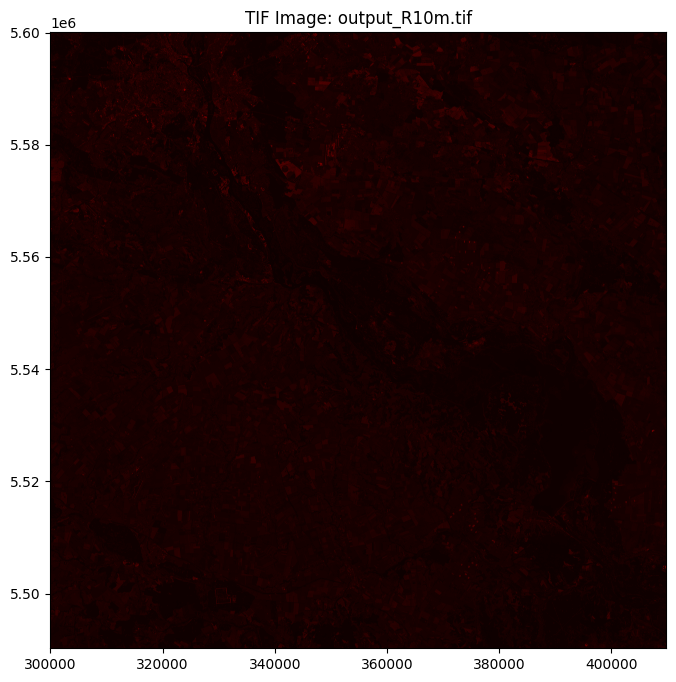

Displaying output_R60m.tif


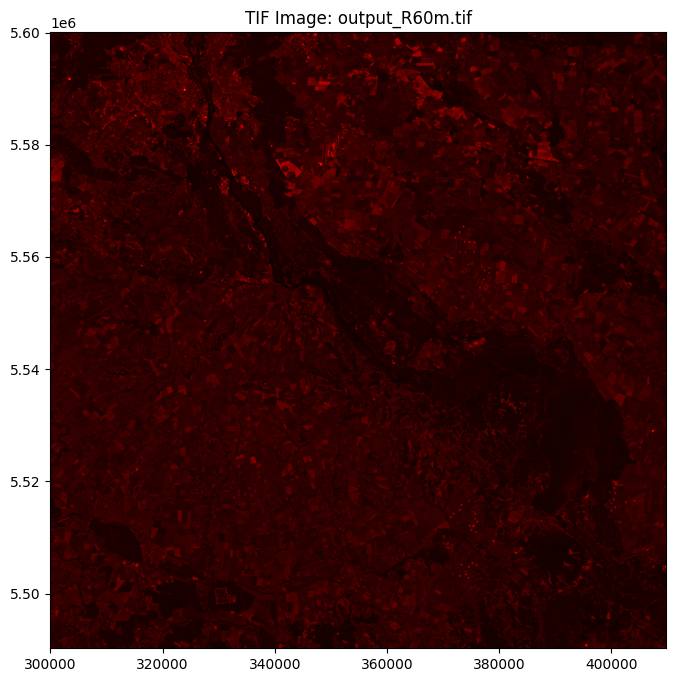

Displaying output_R20m.tif


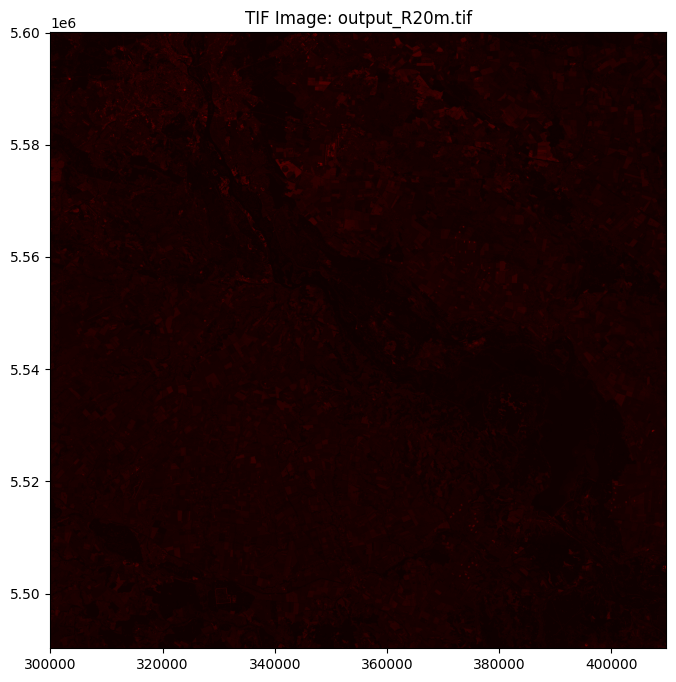

In [ ]:
def display_tif_images(directory, cmap='inferno'):
    # Перевірка, чи існує директорія
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return
    
    # Проходимо по всіх файлах в директорії
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            filepath = os.path.join(directory, filename)
            
            # Відкриття та виведення файлу .tif
            with rasterio.open(filepath) as dataset:
                print(f"Displaying {filename}")
                fig, ax = plt.subplots(figsize=(10, 8))
                img = show(dataset, ax=ax, cmap=cmap)
                
                # Додаємо підпис до картинки
                ax.set_title(f"TIF Image: {filename}")
                
                plt.show()
display_tif_images('./concat_L2A_A/concatenated', cmap='hot') 

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206


Displaying output_R10m.tif


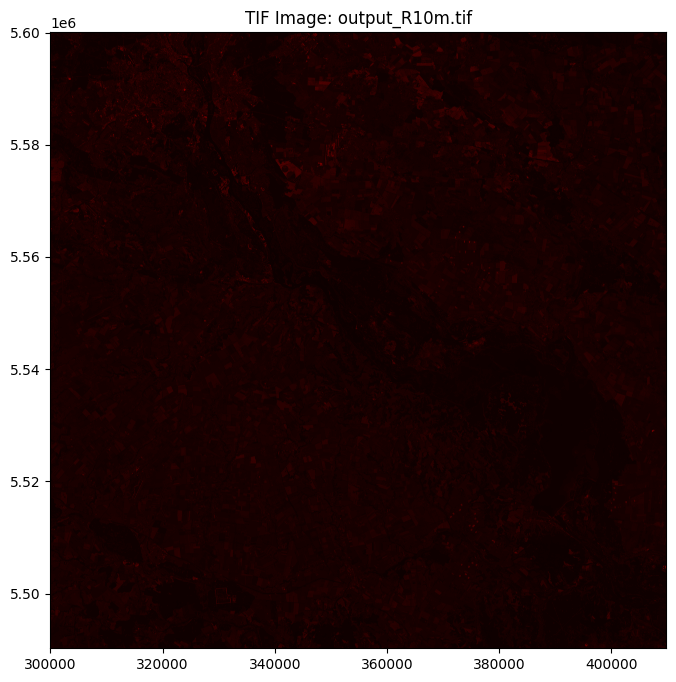

Displaying output_R60m.tif


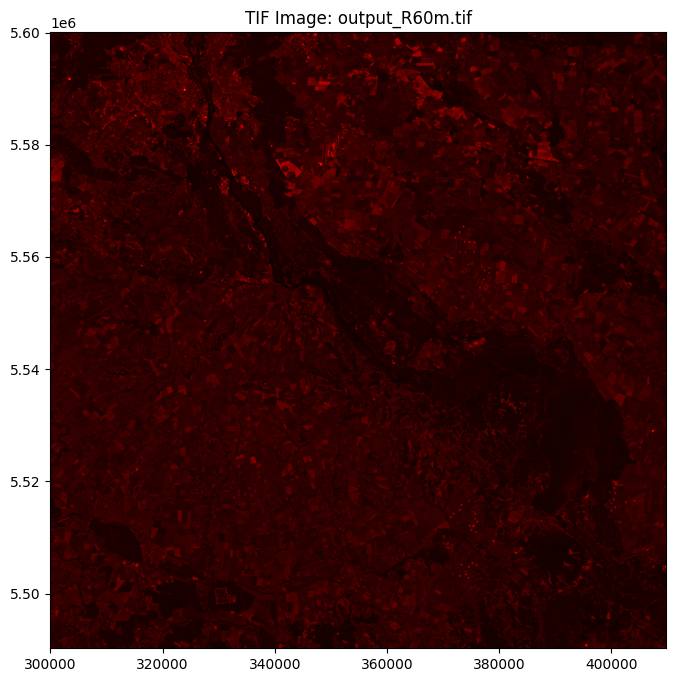

Displaying output_R20m.tif


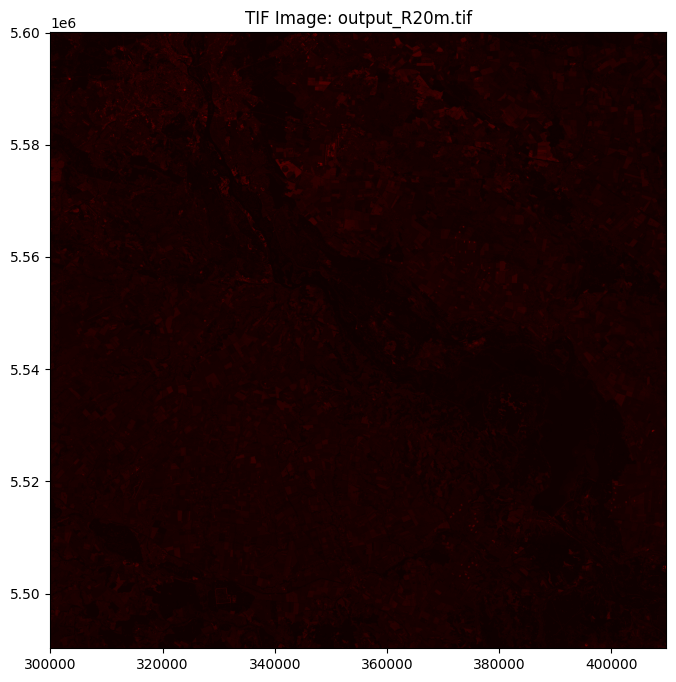

In [15]:
display_tif_images('./concat_L2A_A/concatenated', cmap='hot') 

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206

Перепроектування супутникового зображення у проєкцію 4326.

In [25]:
def reproject_directory(input_dir, output_dir, target_epsg=4326):
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in tqdm(os.listdir(input_dir), desc="Перепроектування файлів"):
        if filename.endswith((".tif", ".tiff")):
            reproject_to_target(
                os.path.join(input_dir, filename),
                os.path.join(output_dir, filename),
                target_epsg
            )

def reproject_to_target(input_raster, output_raster, target_epsg):
    try:
        with gdal.Open(input_raster) as src_ds:
            src_proj = src_ds.GetProjectionRef()
            
            dst_srs = osr.SpatialReference()
            dst_srs.ImportFromEPSG(target_epsg)
            
            gdal.Warp(output_raster, 
                      src_ds, 
                      dstSRS=dst_srs, 
                      transformerOptions=['SRC_SRS='+src_proj, 'DST_SRS='+dst_srs.ExportToWkt()])
        
        print(f"Перепроектування {input_raster} завершено. Вихідний файл: {output_raster}")
    except Exception as e:
        print(f"Помилка при перепроектуванні {input_raster}: {e}")

In [ ]:

input_dir = "./concat_L2A_A/concatenated"
output_dir = "./reproject_L2A_A"  # Не обов'язково, якщо потрібно зберігати в тій самій директорії
reproject_directory(input_dir, output_dir)

Перепроектування файлів:  67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

Перепроектування ./concat_L2A_A/concatenated/output_R10m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R10m.tif
Перепроектування ./concat_L2A_A/concatenated/output_R60m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R60m.tif


Перепроектування файлів: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

Перепроектування ./concat_L2A_A/concatenated/output_R20m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R20m.tif


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

Displaying output_R10m.tif


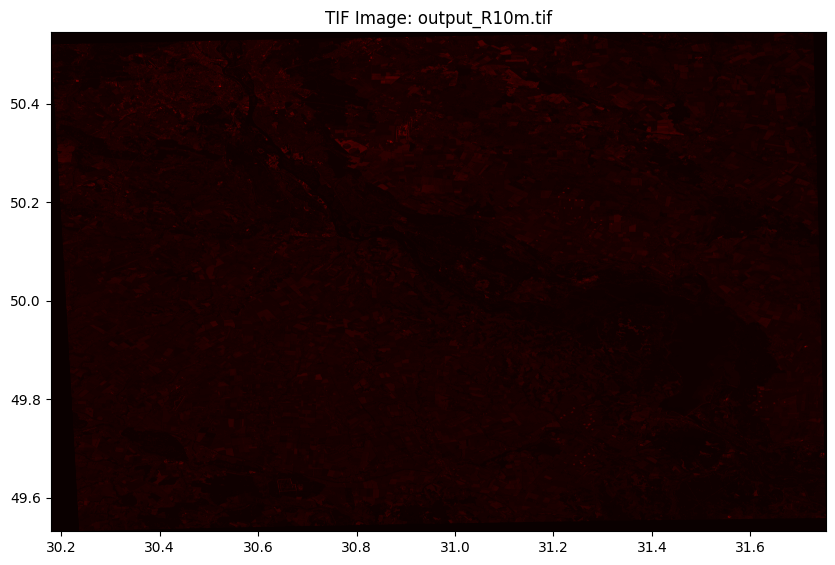

Displaying output_R60m.tif


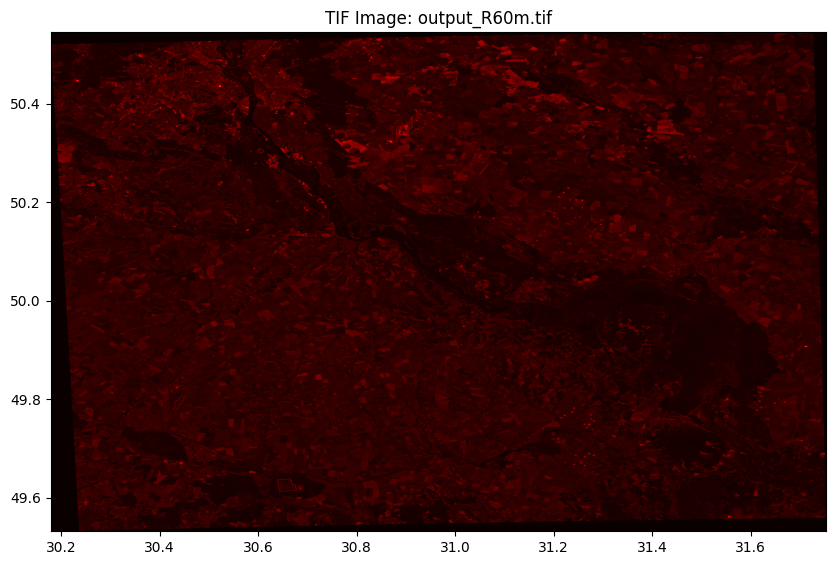

Displaying output_R20m.tif


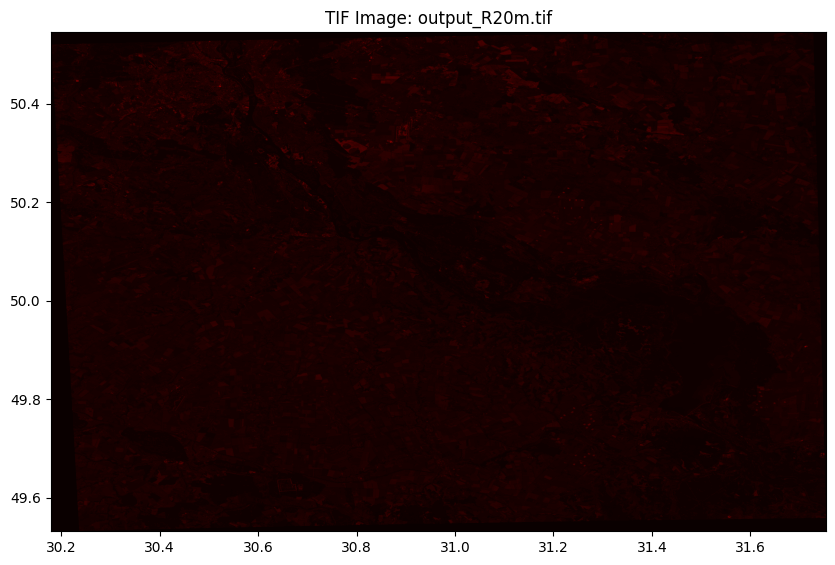

In [27]:
display_tif_images("./reproject_L2A_A", cmap="hot")

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206

In [28]:
input_dir = "./concat_L2A_B/concatenated"
output_dir = "./reproject_L2A_B"  
reproject_directory(input_dir, output_dir)

Перепроектування файлів:  33%|███▎      | 1/3 [00:16<00:32, 16.49s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R10m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R10m.tif


Перепроектування файлів:  67%|██████▋   | 2/3 [00:16<00:07,  7.07s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R60m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R60m.tif


Перепроектування файлів: 100%|██████████| 3/3 [00:20<00:00,  6.98s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R20m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R20m.tif


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

Displaying output_R10m.tif


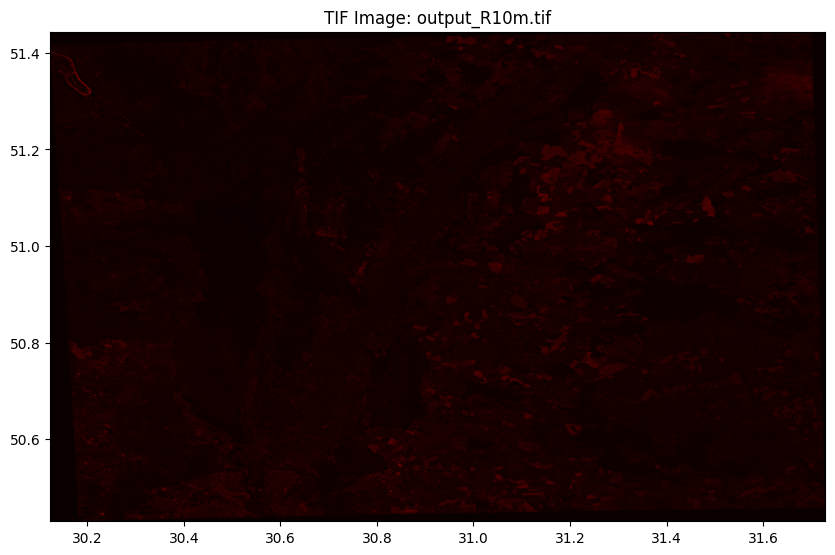

Displaying output_R60m.tif


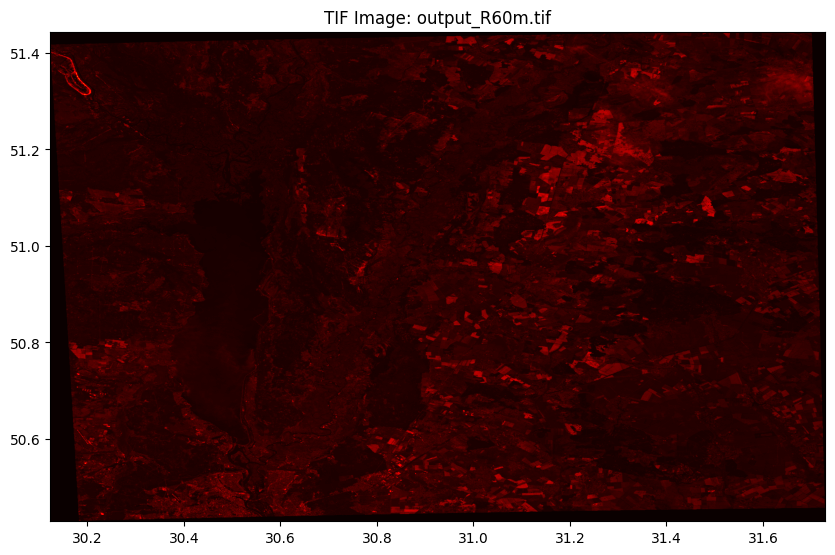

Displaying output_R20m.tif


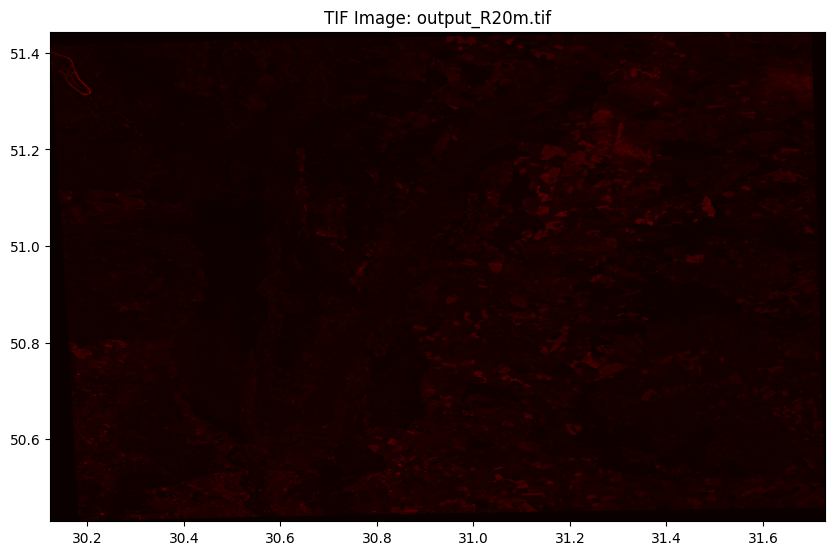

In [29]:
display_tif_images('./reproject_L2A_B', cmap='hot') 